<h2>The average sentiment of tweets related to Corona Virus is computed and a dynamic graph is generated that shows how this average sentiment is changing over time. </h2>
<h3> Sentiment score of 0 is for highly negative and 4 is highly positive </h3>

<h2>Resources used</h2>
<li><span style="color:blue">Spylon kernel</span>: To run scala spark code in Jupyter Notebook</li>
<li><span style="color:blue">twitter4j</span>: Based on the java twitter library, this library provides Spark streaming support for twitter</li>
<li><span style="color:blue">Stanford corenlp</span>: For the sentiment analysis</li>
<li><span style="color:blue">JFree Chart</span>: A java library for drawing charts 

<h2> Loading jars </h2>

In [1]:
%%init_spark
launcher.num_executors = 4
launcher.executor_cores = 2
launcher.driver_memory = '10g'
launcher.jars =["/Users/mohanish/Downloads/stanford-corenlp-3.9.2-models.jar","/Users/mohanish/Downloads/stanford-corenlp-3.9.2.jar",
               "/Users/mohanish/Downloads/jcommon-1.0.23.jar",
               "/Users/mohanish/Downloads/jfreechart-1.0.19.jar"]
launcher.packages= ["databricks:spark-corenlp:0.4.0-spark2.4-scala2.11", "org.apache.bahir:spark-streaming-twitter_2.11:2.4.0"]


<h2> Code</h2>

In [2]:
// Stanford CoreNLP imports
import java.util.Properties 
import scala.collection.JavaConverters._
import edu.stanford.nlp.ling.CoreAnnotations 
import edu.stanford.nlp.neural.rnn.RNNCoreAnnotations 
import edu.stanford.nlp.neural.rnn.RNNCoreAnnotations 
import edu.stanford.nlp.pipeline.{Annotation, StanfordCoreNLP}
import edu.stanford.nlp.sentiment.SentimentCoreAnnotations

// Scala Spark imports
import scala.collection.convert.wrapAll._
import scala.collection.mutable.ArrayBuffer
import org.apache.spark.sql.DataFrame

// JFree Chart Imports
import org.jfree.data.general.Series
import org.jfree.data.xy.XYSeries
import org.jfree.chart.JFreeChart
import org.jfree.chart.ChartFrame
import org.jfree.chart.plot.XYPlot
import org.jfree.chart.plot.PlotOrientation
import org.jfree.chart.ChartFactory
import org.jfree.data.xy.XYSeriesCollection
import org.jfree.chart.ChartColor
import java.awt.Color


//All parameters
val BATCH_SIZE = 20
val NUM_BATCHES = 20
val WINDOW_LENGTH = 60
val SLIDE_DURATION = 40


// Function to return sentiment of a text 
def getSentiment(text: String): Double = {
    val props = new Properties()
    props.setProperty("annotators", "tokenize, ssplit, pos, parse, sentiment")
    val pipeline: StanfordCoreNLP = new StanfordCoreNLP(props)
    val annotation: Annotation = pipeline.process(text)
    val sentences = annotation.get(classOf[CoreAnnotations.SentencesAnnotation])
    val score = sentences.map{i=>
        val tree = i.get(classOf[SentimentCoreAnnotations.SentimentAnnotatedTree])
        val score2 = RNNCoreAnnotations.getPredictedClass(tree).toDouble
    score2 
    }
    score.foldLeft(0.0)((x,y) => x + y) / score.foldLeft(0.0)((x,y) => x + 1) 
}

val words = Array("covid","corona","virus")

// Function to filter tweets related to keywords
def filterData(text: String,words: Array[String]): Boolean = {
    words.map(i=> text.contains(i)).contains(true)
}


//Twitter API keys
val CONSUMER_KEY = "unxsbZGbOWM8XjhIubS######"
val CONSUMER_SECRET = "bDh18etkyeXGsXzBg7pXsRpOHjLfuJY2gbcLpyRxTbib######"
val ACCESS_TOKEN = "1258554890454011916-MqdiUUIOktRmGoK7YM7X41sG######"
val ACCESS_TOKEN_SECRET = "fLciHDhTzPDUbsN4EwRhEyWr4XdLM12Pb5KcSfg######"

//Twitter API keys attached to twitter4j
System.setProperty("twitter4j.oauth.consumerKey",CONSUMER_KEY)
System.setProperty("twitter4j.oauth.consumerSecret",CONSUMER_SECRET)
System.setProperty("twitter4j.oauth.accessToken",ACCESS_TOKEN)
System.setProperty("twitter4j.oauth.accessTokenSecret",ACCESS_TOKEN_SECRET)


//Streaming context and twitter stream set up
import org.apache.spark.streaming.{Seconds, StreamingContext}
import org.apache.spark.streaming.twitter._
val ssc = new StreamingContext(sc,Seconds(BATCH_SIZE.toLong))

val stream = TwitterUtils.createStream(ssc, None)
val tweets = stream.filter(_.getLang == "en")


//text_sentiment_pairs
val text_sentiment_pairs = tweets.map(i=> (i.getText, getSentiment(i.getText)))


//sentiment_array
val sentiment_array = text_sentiment_pairs.map(i=> if (filterData(i._1, words)) i._2 else "None").filter(i => i != "None").map(i=> i.toString.toDouble)  


// Window of length WINDOW_LENGTH, duration SLIDE_DURATION
val sentiment_window = sentiment_array.window(Seconds(WINDOW_LENGTH), Seconds(SLIDE_DURATION))


//FUNCTIONALITY FOR WINDOW AVERAGES
//An ArrayBuffer to hold each (timestamp, average) pair
val all_averages = ArrayBuffer.empty[(String, Double)]

//getAverage function
//args: sentiment array, array buffer, timestamp as string
def getAverage(sentiments: Array[Double], aa: ArrayBuffer[(String,Double)],t: String) = {
    aa += ((t, sentiments.foldLeft(0.0)((a,b) => a+b) / sentiments.foldLeft(0)((a,b) => a+1)))
    aa
}

//computed average for a window and added it, timestamped to all_averages
sentiment_window.foreachRDD((r,t) => (
    getAverage(r.collect, all_averages, t.toString.split(" ")(0).takeRight(7))
    ))


// Graph Creation

val xy = new XYSeries("") 
val dataset = new XYSeriesCollection(xy)

//Creates the chart object 
val chart = ChartFactory.createXYLineChart( 
  "Sentiment Chart",  // chart title 
  "Time",               // x axis label 
  "Sentiment",                   // y axis label 
  dataset,                   // data 
  PlotOrientation.VERTICAL, 
  false,                    // include legend 
  true,                     // tooltips 
  false                     // urls 
)


val plot = chart.getXYPlot() 

def configurePlot(plot: XYPlot): Unit = { 
  plot.setBackgroundPaint(Color.WHITE) 
  plot.setDomainGridlinePaint(Color.BLACK) 
  plot.setRangeGridlinePaint(Color.BLACK) 
  plot.setOutlineVisible(false) 
} 

//A function that shows the chart. This, when called, will pop up the chart in a separate window 
def show(chart: JFreeChart) { 
  val frame = new ChartFrame("plot", chart) 
  frame.pack() 
  frame.setVisible(true) 
}

configurePlot(plot) 
show(chart)


ssc.start
while (all_averages.length <= NUM_BATCHES){
    var current_length = all_averages.length
    Thread.sleep(10)
    if (all_averages.length > 0){
        if (all_averages.length > current_length ){
            for (a <- current_length to all_averages.length-1){
            xy.addOrUpdate(all_averages(a)._1.toDouble , all_averages(a)._2)
            }
        }
        
    }
}
ssc.stop(false)

Intitializing Scala interpreter ...

Spark Web UI available at http://192.168.1.133:4040
SparkContext available as 'sc' (version = 2.4.5, master = local[*], app id = local-1589478224436)
SparkSession available as 'spark'


import java.util.Properties
import scala.collection.JavaConverters._
import edu.stanford.nlp.ling.CoreAnnotations
import edu.stanford.nlp.neural.rnn.RNNCoreAnnotations
import edu.stanford.nlp.neural.rnn.RNNCoreAnnotations
import edu.stanford.nlp.pipeline.{Annotation, StanfordCoreNLP}
import edu.stanford.nlp.sentiment.SentimentCoreAnnotations
import scala.collection.convert.wrapAll._
import scala.collection.mutable.ArrayBuffer
import org.apache.spark.sql.DataFrame
import org.jfree.data.general.Series
import org.jfree.data.xy.XYSeries
import org.jfree.chart.JFreeChart
import org.jfree.chart.ChartFrame
import org.jfree.chart.plot.XYPlot
import org.jfree.chart.plot.PlotOrientation
import org.jfree.chart.ChartFactory
import org.jfree.data.xy.XYSeriesCollection
import org.jfree.chart.ChartCol...

<h2> Sentiment Plot </h2>

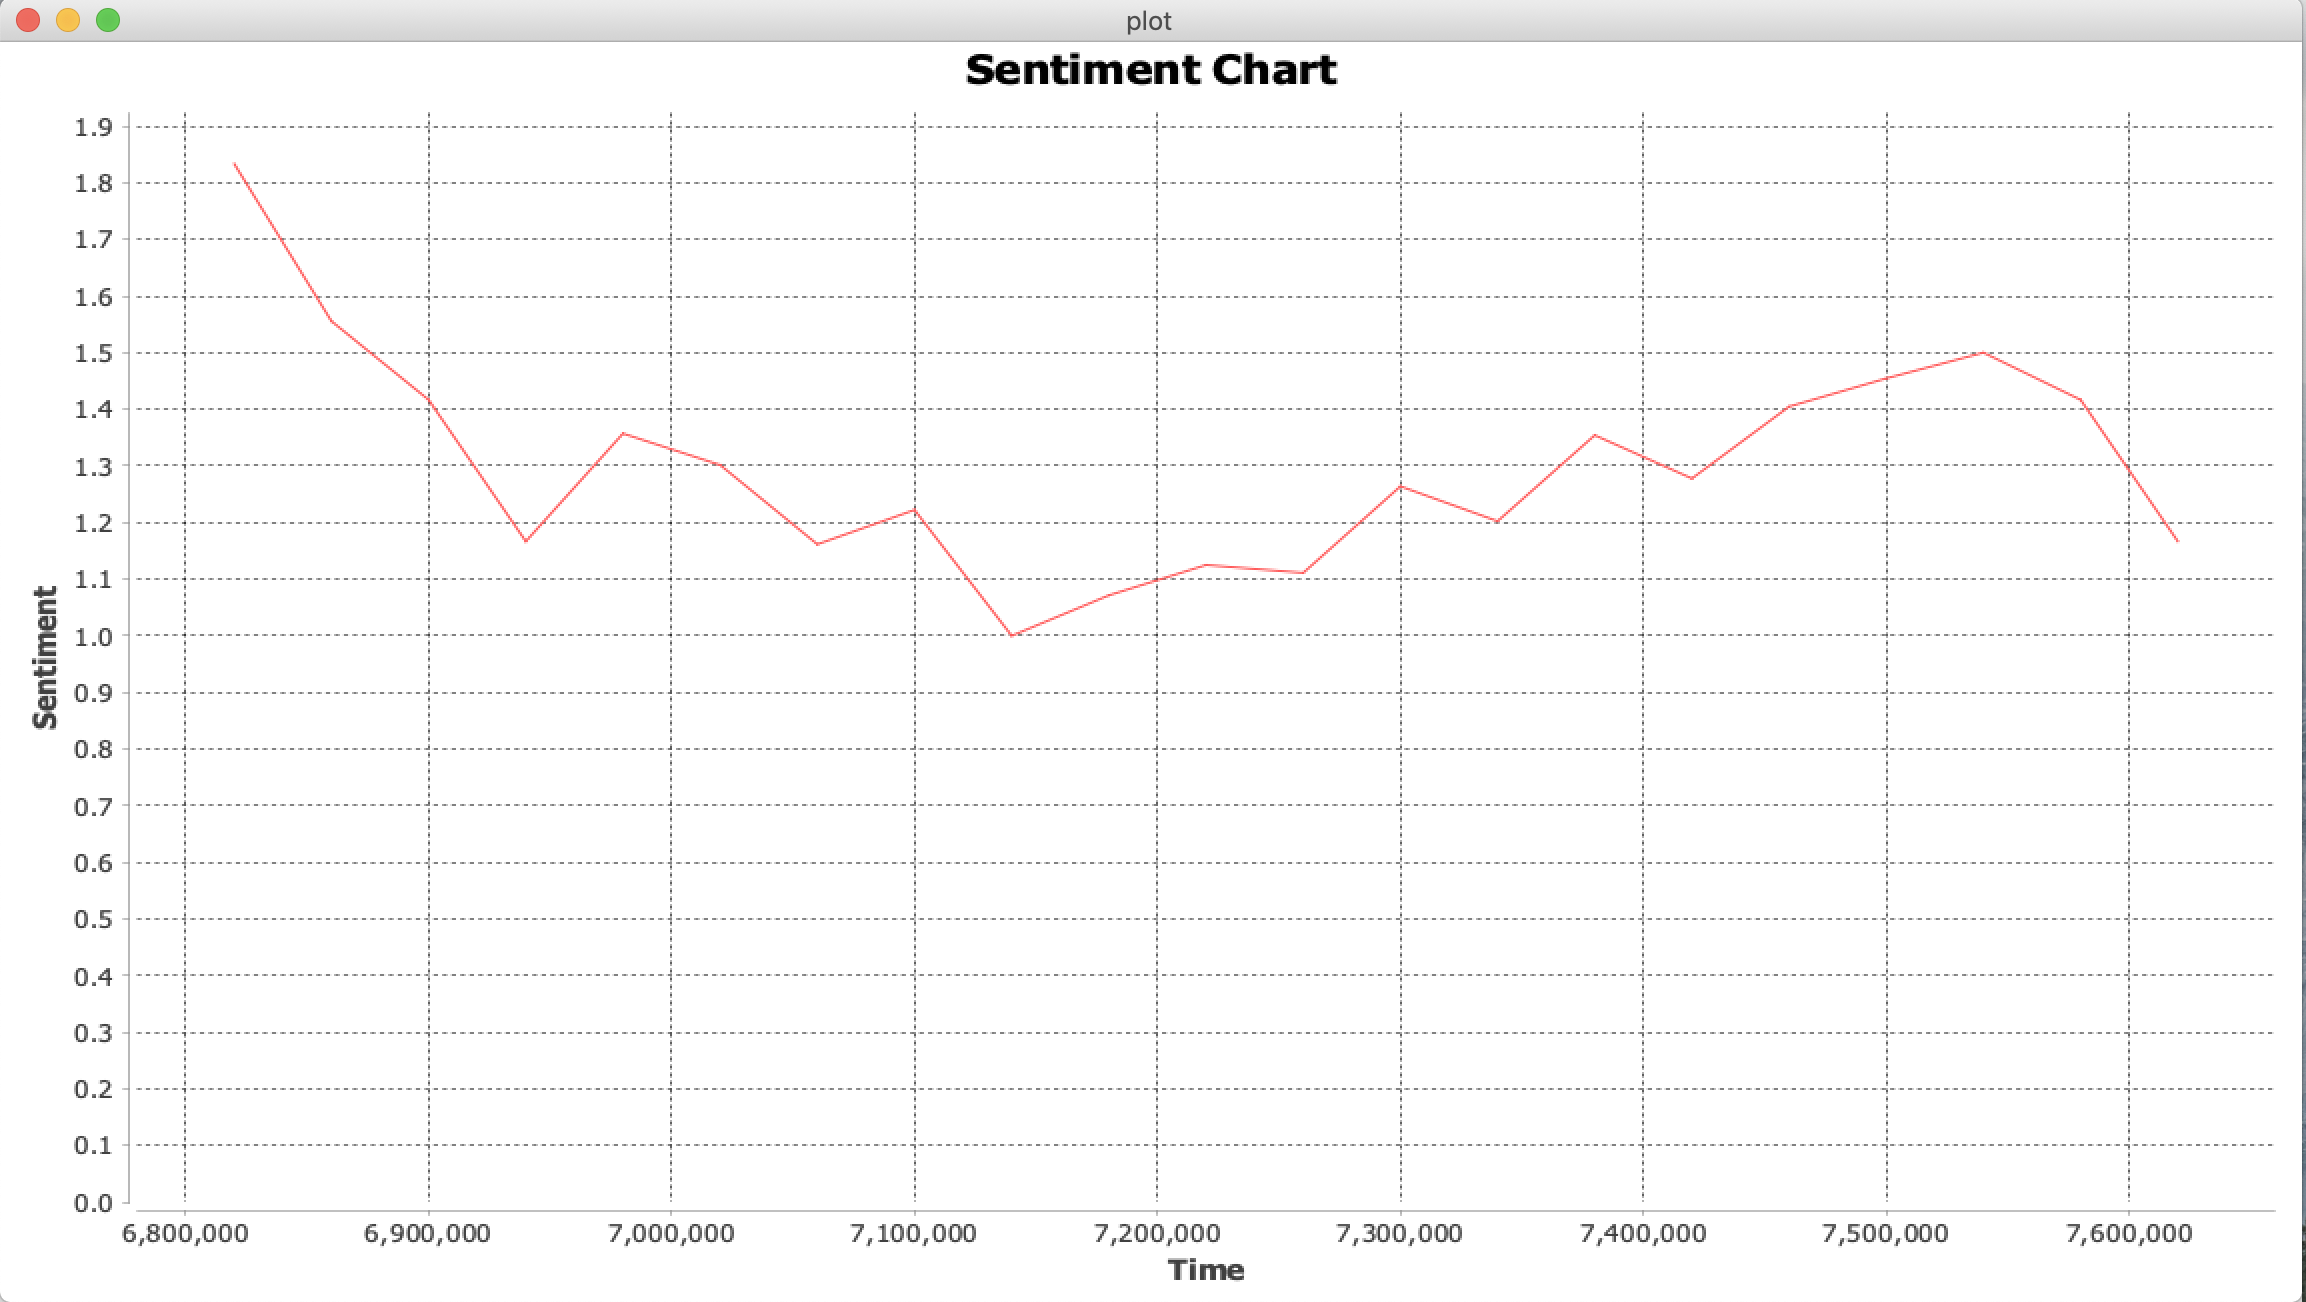

In [3]:
%%python
import matplotlib
matplotlib.use("agg")
from IPython.display import Image
with open("Spark_Streaming.png") as fo:
    retval = Image(filename=fo.name)